In [1]:
import torch
from torchvision.transforms import v2

from torch import nn
from torch.nn import functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
device = (
    "cuda"  # nvidia GPU
    if torch.cuda.is_available()
    else "mps"  # mac GPU
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Prepare dataset

In [3]:
df = pd.read_csv("data/train/train.csv")
df.head(5)

,filename,building,camera,height
0,photo_1_2024-02-28_19-50-55.jpg,"55.83374598606761, 37.4863818073886","55.83355618950865, 37.48563078891009",24
1,photo_2_2024-02-28_19-50-55.jpg,"55.74671515046505, 37.49455264385141","55.74689329318663, 37.49520710283597",21
2,photo_3_2024-02-28_19-50-55.jpg,"55.759007045864244, 37.71650413890229","55.758900299637965, 37.71613626315986",18
3,photo_4_2024-02-28_19-50-55.jpg,"55.781247169148855, 37.540942963066165","55.78183117969778, 37.54023985374589",18
4,photo_5_2024-02-28_19-50-55.jpg,"55.63435687287336, 37.765668872386286","55.63416610435083, 37.76433849674555",51


In [4]:
class CoordinatesTransformPipeline:
    def __init__(self, df: pd.DataFrame):
        self.df = df
        
    @staticmethod
    def distance(x: np.ndarray, y: np.ndarray) -> float:
        """
        Great-circle distance: https://en.wikipedia.org/wiki/Great-circle_distance
        Returns distance between x and y in meters
        """
        x, y = np.radians(x), np.radians(y)
        r = 6_371_000  # meters
        delta_lambda = np.abs(x[1] - y[1])
        return np.arccos(np.sin(x[0]) * np.sin(y[0]) + 
                         np.cos(x[0]) * np.cos(y[0]) * 
                         np.cos(delta_lambda)) * r
    
    def transform(self) -> pd.DataFrame:
        coords_columns = ["building", "camera"]

        for col in coords_columns:
            self.df[col] = self.coords_transform(self.df[col])

        dists = []
        for i in range(len(self.df)):
            dists.append(self.distance(
                self.df[coords_columns[0]].iloc[i],
                self.df[coords_columns[1]].iloc[i]
            ))
        self.df["distance"] = pd.Series(dists)
        return self.df.drop(columns=coords_columns)[["filename", "distance", "height"]]
            
    
    def coords_transform(self, column: pd.Series) -> pd.Series:
        splited = column.str.split(",")
        result = []
        for i in range(len(self.df)):
            result.append(np.array(
                splited.iloc[i], 
                dtype=np.float64)
            )
        return pd.Series(result)

In [5]:
transformer = CoordinatesTransformPipeline(df)
df = transformer.transform()
df.head(5)

,filename,distance,height
0,photo_1_2024-02-28_19-50-55.jpg,51.428476,24
1,photo_2_2024-02-28_19-50-55.jpg,45.498280,21
2,photo_3_2024-02-28_19-50-55.jpg,25.896985,18
3,photo_4_2024-02-28_19-50-55.jpg,78.422418,18
4,photo_5_2024-02-28_19-50-55.jpg,86.155339,51


In [6]:
class BuildingDataset(torch.utils.data.Dataset):
    """
    Torch dataset
    
    Returns tuple of form: tensor_image, tensor_dist, tensor_y
    (resize image to 400x400 pixels)
    
    - tensor_image is image of shape (n_channels, height, width),
    - tensor_dist is distance between camera and building in meters,
    - tensor_y is target.
    """
    normalize_params = {
        "mean": None,
        "std": None
    }
    
    def __init__(self, folder: str, df: pd.DataFrame):
        self.df = df
        self.df[["distance", "height"]] = self.numerical_normalize(self.df[["distance", "height"]])
        self.folder = folder
        
    def __len__(self) -> int:
        return len(self.df)
    
    @staticmethod
    def image2tensor(pic: Image, size: tuple[int, int], device: str = None,) -> torch.Tensor:
        # картинка приводится к размеру 400*400, величина каждого пикселя делится на 255
        img = v2.Resize(size)(pic)
        img = torch.as_tensor(np.array(img, copy=True), device=device, dtype=torch.float32) / 255
        img = img.view(size[1], size[0], 3)
        # put it from HWC to CHW format
        img = img.permute((2, 0, 1))
        return img

    def numerical_normalize(self, data: pd.DataFrame | float | int) -> pd.DataFrame | float:
        """
        Returns normalized data.
        """
        if self.normalize_params["mean"] is None and self.normalize_params["std"] is None:
            self.normalize_params["mean"] = data.mean()
            self.normalize_params["std"] = data.std()

        # z-нормализация
        data = (data - self.normalize_params["mean"]) / self.normalize_params["std"]
        return data

    def __getitem__(self, key: int) -> tuple[torch.Tensor,
                                             torch.Tensor,
                                             torch.Tensor]:
        filename = f"{self.folder}/{self.df['filename'].iloc[key]}"
        
        return (self.image2tensor(Image.open(filename), size=(400, 400), device=device),
                torch.tensor(self.df["distance"].iloc[key], device=device, dtype=torch.float32),
                torch.tensor(self.df["height"].iloc[key], device=device, dtype=torch.float32))

torch.Size([3, 400, 400]) torch.Size([]) torch.Size([])


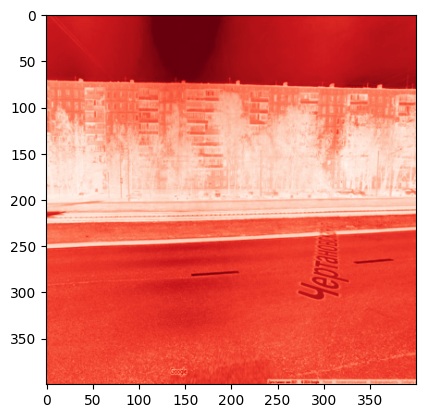

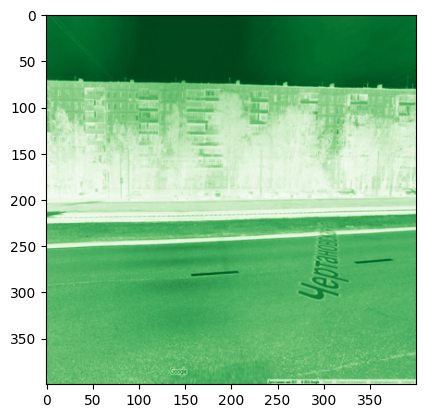

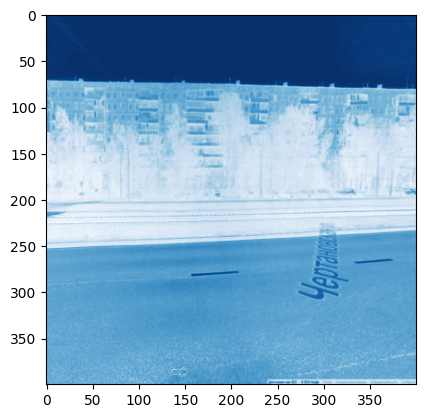

tensor(0.7212, device='cuda:0') tensor(0.0872, device='cuda:0')


In [7]:
train_df, test_df, y_train_df, y_test_df = train_test_split(df.loc[:, :'distance'], df.loc[:, 'height'], test_size=0.2)
train_df = train_df.assign(height=y_train_df)
test_df = test_df.assign(height=y_test_df)
train_dataset = BuildingDataset("data/train", train_df)
test_dataset = BuildingDataset("data/train", test_df)
for image, x, y in test_dataset:
    print(image.shape, x.shape, y.shape)
    for channel, cm in zip(image, ["Reds", "Greens", "Blues"]):
        plt.imshow(channel.to("cpu"), cmap=cm)
        plt.show()
    print(x, y)
    break

In [8]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=(device != 'cuda'))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, pin_memory=(device != 'cuda'))

# test batches
for i, (image, x, y) in enumerate(train_dataloader):
    print(f"Batch num: {i}, input: {image.shape}, {x.shape}, {y.shape}, devices: {image.device}, {x.device}, {y.device}", end="\n\n")

Batch num: 0, input: torch.Size([4, 3, 400, 400]), torch.Size([4]), torch.Size([4]), devices: cuda:0, cuda:0, cuda:0

Batch num: 1, input: torch.Size([4, 3, 400, 400]), torch.Size([4]), torch.Size([4]), devices: cuda:0, cuda:0, cuda:0

Batch num: 2, input: torch.Size([4, 3, 400, 400]), torch.Size([4]), torch.Size([4]), devices: cuda:0, cuda:0, cuda:0

Batch num: 3, input: torch.Size([4, 3, 400, 400]), torch.Size([4]), torch.Size([4]), devices: cuda:0, cuda:0, cuda:0


# Develop NN architecture

## Loss

In [9]:
loss = nn.HuberLoss()
lr = 1e-3
epochs = 200

## Accuracy

In [10]:
accuracy = nn.L1Loss()

## Train, Test loops

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer) -> float:
    size = len(dataloader)
    losses = []
    
    model.train()
    for batch, (image, dist, y) in enumerate(dataloader):
        pred = model((image, dist)).squeeze()
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.item())
        print(f"loss: {loss:>7f}  [{batch + 1}/{size}]")
    losses = np.array(losses)

    return losses.mean()


def test_loop(dataloader, model, accuracy_fn) -> float:
    model.eval()
    accuracies = []

    with torch.no_grad():
        for image, dist, y in dataloader:
            pred = model((image, dist)).squeeze()
            accuracies.append(accuracy_fn(pred, y).item())
    accuracies = np.array(accuracies)
    
    print(f"Avg accuracy: {accuracies.mean():>8f} \n")
    
    return accuracies.mean()


def main_loop(train_dataloader, test_dataloader, model, optimizer, loss, accuracy, epochs):
    train_losses = []
    test_accuracies = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n-------------------------------")
        train_losses.append(train_loop(train_dataloader, model, loss, optimizer))
        test_accuracies.append(test_loop(test_dataloader, model, accuracy))
    print("Done!")
    
    plt.plot(range(1, epochs + 1), train_losses, color="red", label="Train loss")
    plt.legend()
    plt.grid()
    plt.title("Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show();
    plt.plot(range(1, epochs + 1), test_accuracies, color="blue", label="Test loss")
    plt.legend()
    plt.grid()
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show();

In [12]:
from networks import Inceptionv4
from networks import AlexNet
from networks import ResNet34
from networks import ResNet18

## AlexNet

In [13]:
alexnet = AlexNet().to(device)
optimizer = torch.optim.Adam(alexnet.parameters(), lr=lr)

Epoch 1
-------------------------------
loss: 0.168236  [1/4]
loss: 59.132652  [2/4]
loss: 0.712441  [3/4]
loss: 0.781706  [4/4]
Avg accuracy: 0.526863 

Epoch 2
-------------------------------
loss: 0.668546  [1/4]
loss: 0.196623  [2/4]
loss: 0.319453  [3/4]
loss: 0.737327  [4/4]
Avg accuracy: 0.319040 

Epoch 3
-------------------------------
loss: 0.606728  [1/4]
loss: 0.356169  [2/4]
loss: 0.144308  [3/4]
loss: 0.313730  [4/4]
Avg accuracy: 0.406917 

Epoch 4
-------------------------------
loss: 0.120404  [1/4]
loss: 0.282536  [2/4]
loss: 0.058964  [3/4]
loss: 0.345633  [4/4]
Avg accuracy: 0.807775 

Epoch 5
-------------------------------
loss: 0.077420  [1/4]
loss: 0.099855  [2/4]
loss: 0.088122  [3/4]
loss: 0.048789  [4/4]
Avg accuracy: 1.004099 

Epoch 6
-------------------------------
loss: 0.035888  [1/4]
loss: 0.219303  [2/4]
loss: 0.231280  [3/4]
loss: 0.135380  [4/4]
Avg accuracy: 1.120899 

Epoch 7
-------------------------------
loss: 0.045352  [1/4]
loss: 0.029755  [2/

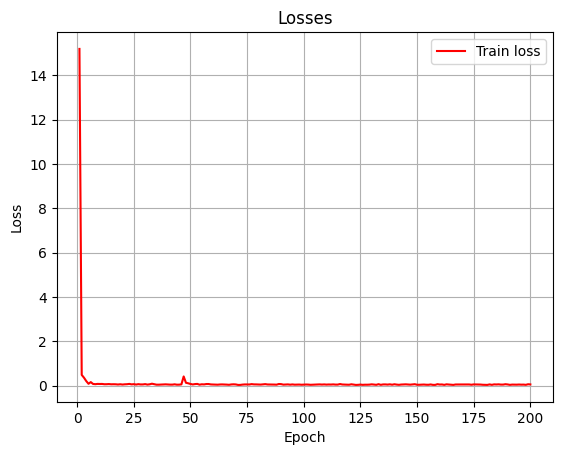

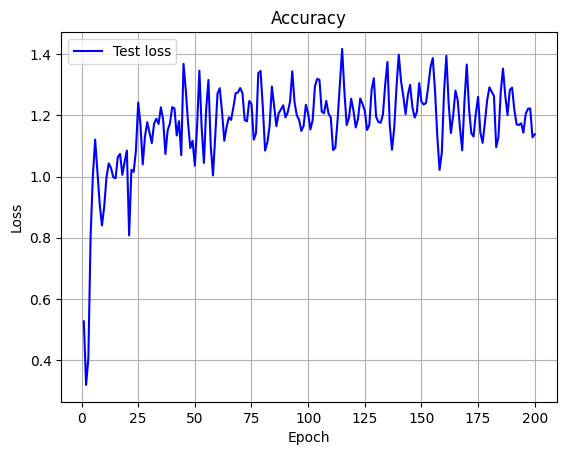

In [14]:
main_loop(train_dataloader, test_dataloader, alexnet, optimizer, loss, accuracy, epochs)
torch.save(alexnet, 'models/alexnet.pth')

## ResNet34

In [15]:
resnet34 = ResNet34().to(device)
optimizer = torch.optim.Adam(resnet34.parameters(), lr=lr)

Epoch 1
-------------------------------
loss: 0.530414  [1/4]
loss: 1.975107  [2/4]
loss: 0.329383  [3/4]
loss: 0.752794  [4/4]
Avg accuracy: 0.381623 

Epoch 2
-------------------------------
loss: 0.836642  [1/4]
loss: 0.636135  [2/4]
loss: 0.180652  [3/4]
loss: 0.643990  [4/4]
Avg accuracy: 0.243587 

Epoch 3
-------------------------------
loss: 0.469247  [1/4]
loss: 0.829677  [2/4]
loss: 0.723701  [3/4]
loss: 0.428473  [4/4]
Avg accuracy: 0.244563 

Epoch 4
-------------------------------
loss: 0.359314  [1/4]
loss: 0.778000  [2/4]
loss: 0.217694  [3/4]
loss: 0.820768  [4/4]
Avg accuracy: 0.245606 

Epoch 5
-------------------------------
loss: 0.057300  [1/4]
loss: 0.508755  [2/4]
loss: 0.507389  [3/4]
loss: 0.582794  [4/4]
Avg accuracy: 0.292223 

Epoch 6
-------------------------------
loss: 0.415757  [1/4]
loss: 0.777276  [2/4]
loss: 0.082159  [3/4]
loss: 0.222260  [4/4]
Avg accuracy: 0.380306 

Epoch 7
-------------------------------
loss: 0.396809  [1/4]
loss: 0.197068  [2/4

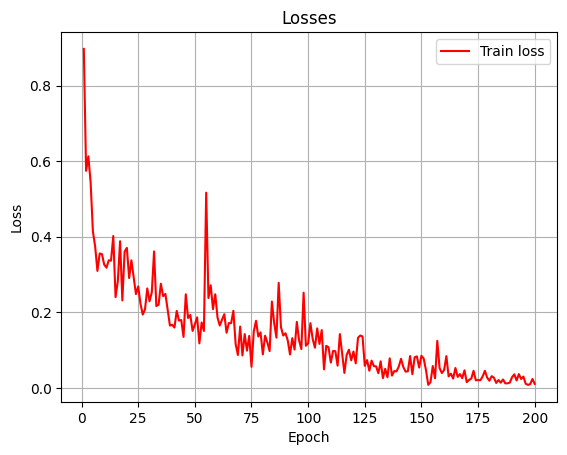

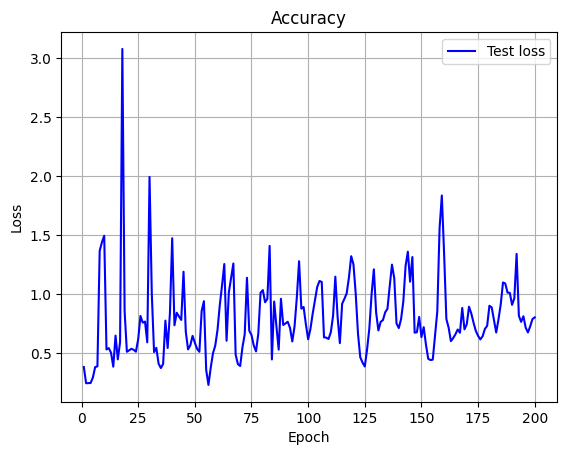

In [16]:
main_loop(train_dataloader, test_dataloader, resnet34, optimizer, loss, accuracy, epochs)
torch.save(resnet34, 'models/resnet34.pth')

## ResNet18

In [17]:
resnet18 = ResNet18().to(device)
optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr)

Epoch 1
-------------------------------
loss: 0.687258  [1/4]
loss: 1.857202  [2/4]
loss: 1.384027  [3/4]
loss: 1.035509  [4/4]
Avg accuracy: 0.539771 

Epoch 2
-------------------------------
loss: 0.293647  [1/4]
loss: 0.563218  [2/4]
loss: 0.832992  [3/4]
loss: 0.358680  [4/4]
Avg accuracy: 9.614727 

Epoch 3
-------------------------------
loss: 0.380698  [1/4]
loss: 0.604103  [2/4]
loss: 0.268106  [3/4]
loss: 0.133434  [4/4]
Avg accuracy: 1.814180 

Epoch 4
-------------------------------
loss: 0.289303  [1/4]
loss: 0.273215  [2/4]
loss: 0.172871  [3/4]
loss: 0.783463  [4/4]
Avg accuracy: 1.032451 

Epoch 5
-------------------------------
loss: 0.195823  [1/4]
loss: 0.531509  [2/4]
loss: 0.153048  [3/4]
loss: 0.366118  [4/4]
Avg accuracy: 1.310066 

Epoch 6
-------------------------------
loss: 0.147036  [1/4]
loss: 0.207533  [2/4]
loss: 0.220730  [3/4]
loss: 0.418570  [4/4]
Avg accuracy: 0.585801 

Epoch 7
-------------------------------
loss: 0.148275  [1/4]
loss: 0.359554  [2/4

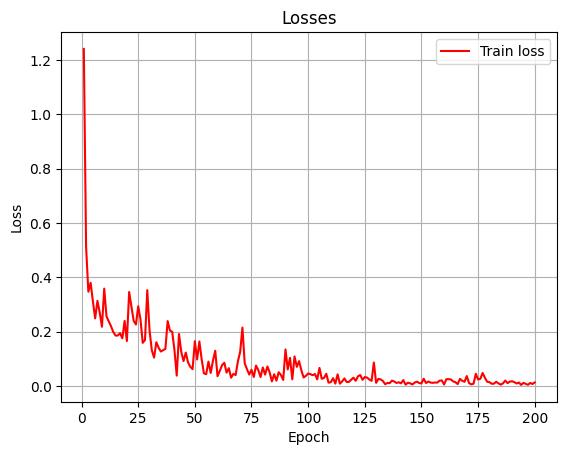

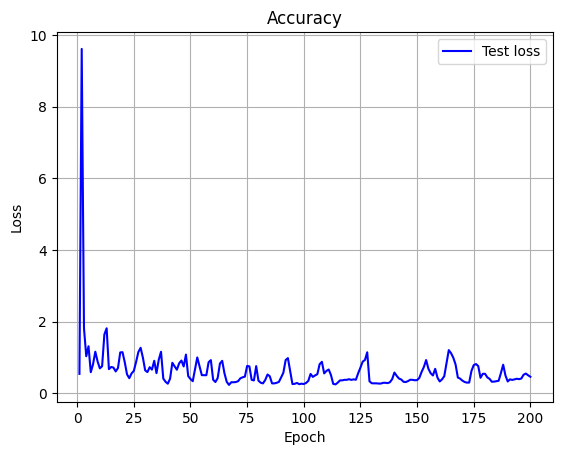

In [18]:
main_loop(train_dataloader, test_dataloader, resnet18, optimizer, loss, accuracy, epochs)
torch.save(resnet18, 'models/resnet18.pth')

## Inception V4

In [19]:
inception = Inceptionv4().to(device)
optimizer = torch.optim.Adam(inception.parameters(), lr=lr)

Epoch 1
-------------------------------
loss: 0.634268  [1/4]
loss: 16.550957  [2/4]
loss: 6.088345  [3/4]
loss: 22.610622  [4/4]
Avg accuracy: 1.149882 

Epoch 2
-------------------------------
loss: 29.551229  [1/4]
loss: 11.200432  [2/4]
loss: 1.351987  [3/4]
loss: 8.897599  [4/4]
Avg accuracy: 0.249428 

Epoch 3
-------------------------------
loss: 15.591661  [1/4]
loss: 0.747871  [2/4]
loss: 11.509324  [3/4]
loss: 6.514795  [4/4]
Avg accuracy: 0.314737 

Epoch 4
-------------------------------
loss: 3.577112  [1/4]
loss: 3.542006  [2/4]
loss: 6.026821  [3/4]
loss: 1.904625  [4/4]
Avg accuracy: 2.121239 

Epoch 5
-------------------------------
loss: 2.814357  [1/4]
loss: 6.129980  [2/4]
loss: 8.534037  [3/4]
loss: 1.241254  [4/4]
Avg accuracy: 0.308792 

Epoch 6
-------------------------------
loss: 2.012758  [1/4]
loss: 6.672073  [2/4]
loss: 6.804691  [3/4]
loss: 1.790580  [4/4]
Avg accuracy: 0.251529 

Epoch 7
-------------------------------
loss: 1.901031  [1/4]
loss: 3.539742

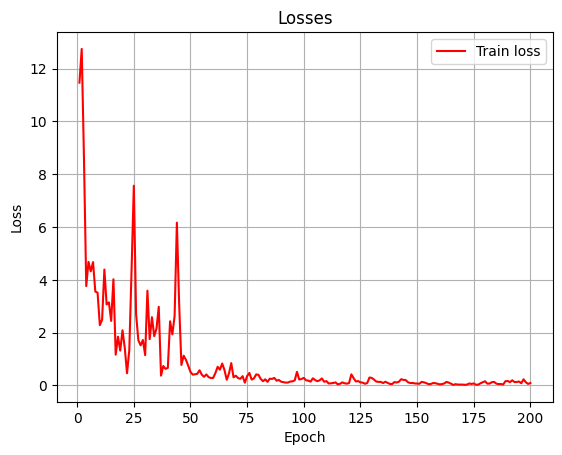

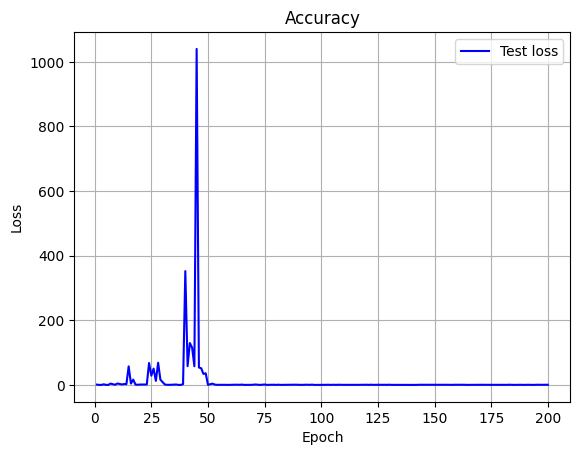

In [20]:
main_loop(train_dataloader, test_dataloader, inception, optimizer, loss, accuracy, epochs)
torch.save(inception, 'models/inception.pth')